In [9]:
#IMPORTING LIBRARIES
import sys
import os
import cv2
import torch
import numpy as np
import pandas as pd
from torchvision import transforms

In [10]:
#Adds the folder to the system path and importing vgg19 model from models 
dmcount_path = '/home/harshit-singh-mehta/Downloads/MACHINE LEARNING/Project/DM-Count'
sys.path.append(dmcount_path)
from models import vgg19

In [11]:
video_dir = '/home/harshit-singh-mehta/Downloads'
video_files = ['IITB1.mp4', 'IITB2.mp4', 'IITB3.mp4']
model_path = os.path.join(dmcount_path, 'save_model/NWPU/model_nwpu.pth')
output_dir = os.path.join(dmcount_path, 'outputs/IIT-B Testing')
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = vgg19()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_6939/3140217030.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [14]:
all_results = []

for video_name in video_files:
    video_path = os.path.join(video_dir, video_name)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ Cannot open video: {video_name}")
        continue

    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps * 2)  # every 2 seconds
    video_base = os.path.splitext(video_name)[0]
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_id = 0
    save_id = 0

    print(f"📹 Processing {video_name} ...")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_id % interval == 0:
            # Resize and preprocess
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_resized = cv2.resize(frame_rgb, (1024, 768))
            input_tensor = transform(frame_resized).unsqueeze(0).to(device)

            with torch.no_grad():
                output, _ = model(input_tensor)
            count = output.sum().item()

            # Density map → heatmap
            density_map = output.squeeze().cpu().numpy()
            norm_map = (density_map - density_map.min()) / (density_map.max() - density_map.min() + 1e-5)
            heatmap = (norm_map * 255).astype(np.uint8)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

            # Overlay
            frame_resized_bgr = cv2.resize(frame, (1024, 768))
            heatmap_resized = cv2.resize(heatmap, (1024, 768))
            overlay = cv2.addWeighted(frame_resized_bgr, 0.6, heatmap_resized, 0.4, 0)
            cv2.putText(overlay, f'Count: {count:.2f}', (30, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255, 255, 255), 3)

            # Save image
            output_filename = f"{video_base}_frame{save_id:03d}.jpg"
            output_path = os.path.join(output_dir, output_filename)
            cv2.imwrite(output_path, overlay)

            # Save result to list
            all_results.append({
                "video": video_name,
                "frame_num": frame_id,
                "timestamp_sec": round(frame_id / fps, 2),
                "estimated_count": round(count, 2),
                "image_saved_as": output_filename
            })

            save_id += 1

        frame_id += 1

    cap.release()
    print(f"✅ Done: {video_name} → {save_id} frames saved")

📹 Processing IITB1.mp4 ...


/home/harshit-singh-mehta/Downloads/MACHINE LEARNING/Project/DM-Count/models.py:24: UserWarning: `nn.functional.upsample_bilinear` is deprecated. Use `nn.functional.interpolate` instead.
  x = F.upsample_bilinear(x, scale_factor=2)


✅ Done: IITB1.mp4 → 7 frames saved
📹 Processing IITB2.mp4 ...
✅ Done: IITB2.mp4 → 10 frames saved
📹 Processing IITB3.mp4 ...
✅ Done: IITB3.mp4 → 4 frames saved


In [15]:
df = pd.DataFrame(all_results)
csv_path = os.path.join(output_dir, "inference_results.csv")
df.to_csv(csv_path, index=False)
print(f"\n📊 CSV saved at: {csv_path}")


📊 CSV saved at: /home/harshit-singh-mehta/Downloads/MACHINE LEARNING/Project/DM-Count/outputs/IIT-B Testing/inference_results.csv


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
csv_path = '/home/harshit-singh-mehta/Downloads/MACHINE LEARNING/Project/DM-Count/outputs/IIT-B Testing/inference_results.csv'
df = pd.read_csv(csv_path)

In [19]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


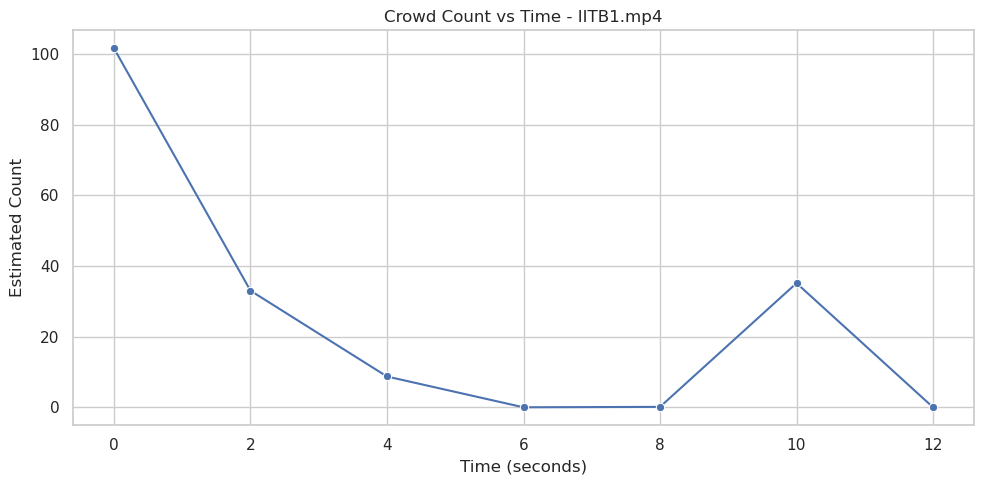

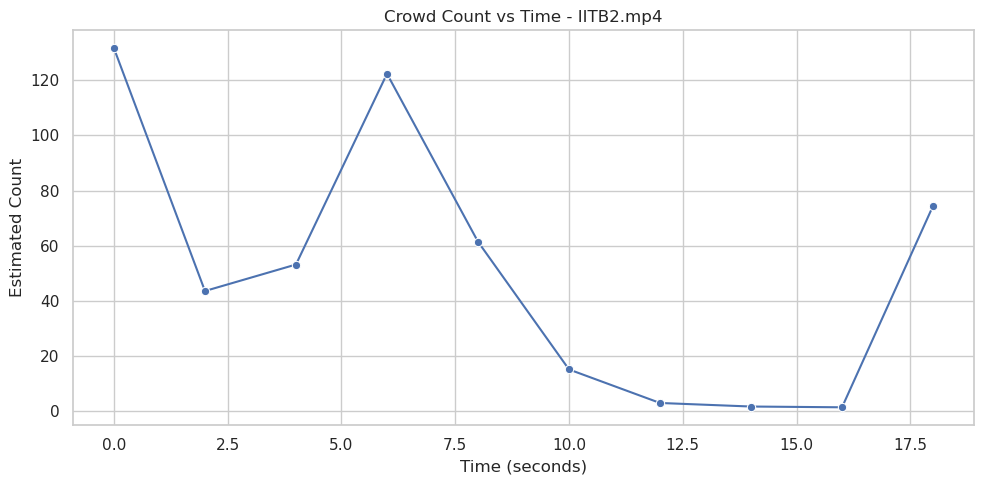

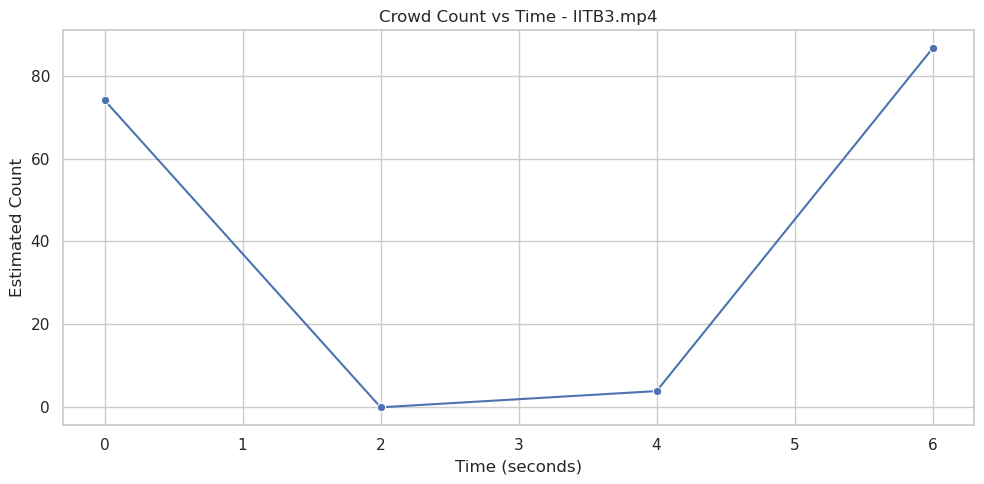

In [20]:
video_names = df['video'].unique()

for video in video_names:
    video_df = df[df['video'] == video]

    plt.figure()
    sns.lineplot(data=video_df, x='timestamp_sec', y='estimated_count', marker="o")
    plt.title(f"Crowd Count vs Time - {video}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Estimated Count")
    plt.tight_layout()

    # Optional: Save the plot as PNG
    save_path = f'/home/harshit-singh-mehta/Downloads/MACHINE LEARNING/Project/DM-Count/outputs/IIT-B Testing/{video}_graph.png'
    plt.savefig(save_path)
    plt.show()